In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib
import numpy as np

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

In [4]:

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [198]:
width = 0.03
ang = jnp.pi
num_position_grids = 51
num_angle_grids = 51
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    num_position_grids,num_position_grids,num_angle_grids
)

grid_params = [
    (0.3, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)), (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)), (0.02, jnp.pi, (9,9,51)), (0.01, jnp.pi/5, (15,15,15)), (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [199]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
face_child = 3
cp_to_pose = lambda cp: table_pose@ b.scene_graph.relative_pose_from_edge(cp, face_child, b.RENDERER.model_box_dims[13])
cp_to_pose_jit = jax.jit(cp_to_pose)
cp_to_pose_parallel = jax.jit(jax.vmap(cp_to_pose, in_axes=(0,)))

key = jax.random.PRNGKey(30)


In [332]:
def score_images(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

# def score_images(rendered, observed):
#     mask = observed[...,2] < intrinsics.far
#     return (jnp.linalg.norm(observed - rendered, axis=-1)* (1.0 * mask)).sum() / mask.sum()

def score_images(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

def score_images(rendered, observed):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    probabilities_per_pixel = jax.scipy.stats.norm.logpdf(
        distances,
        loc=0.0, 
        scale=0.02
    )
    image_probability = probabilities_per_pixel.mean()
    return image_probability

def score_images(rendered, observed):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    width = 0.02
    probabilities_per_pixel = (distances < width/2) / width
    return probabilities_per_pixel.mean()

score_vmap = jax.jit(jax.vmap(score_images, in_axes=(0, None)))

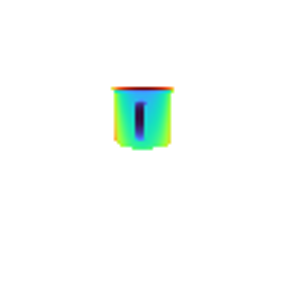

In [330]:
key = jax.random.split(key,2)[0]
key = jnp.array([2755247810, 1586593754], dtype=np.uint32)
low, high = jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])
gt_cp = jax.random.uniform(key, shape=(3,),minval=low, maxval=high)
gt_pose = cp_to_pose_jit(gt_cp)
obs_img = b.RENDERER.render(gt_pose[None,...], jnp.array([13]))[...,:3]
b.viz.scale_image(b.get_depth_image(obs_img[...,2]),3.0)

GT CP:  [ 0.01171646 -0.04043575  0.0145421 ]
[50.       49.995    49.985    49.98     49.975    49.975    49.975
 49.975    49.969997 49.969997]
[[ 0.01171646 -0.04043575  0.0145421 ]
 [ 0.01171646 -0.04163574  0.0145421 ]
 [ 0.01171646 -0.03923575  0.0145421 ]
 [ 0.01291645 -0.04163574  0.0145421 ]
 [ 0.01171646 -0.04283575  0.0145421 ]
 [ 0.01291645 -0.04043575  0.0145421 ]
 [ 0.01291645 -0.03923575  0.0145421 ]
 [ 0.01171646 -0.03803575  0.0145421 ]
 [ 0.01291645 -0.04283575  0.0145421 ]
 [ 0.01171646 -0.03683574  0.0145421 ]]


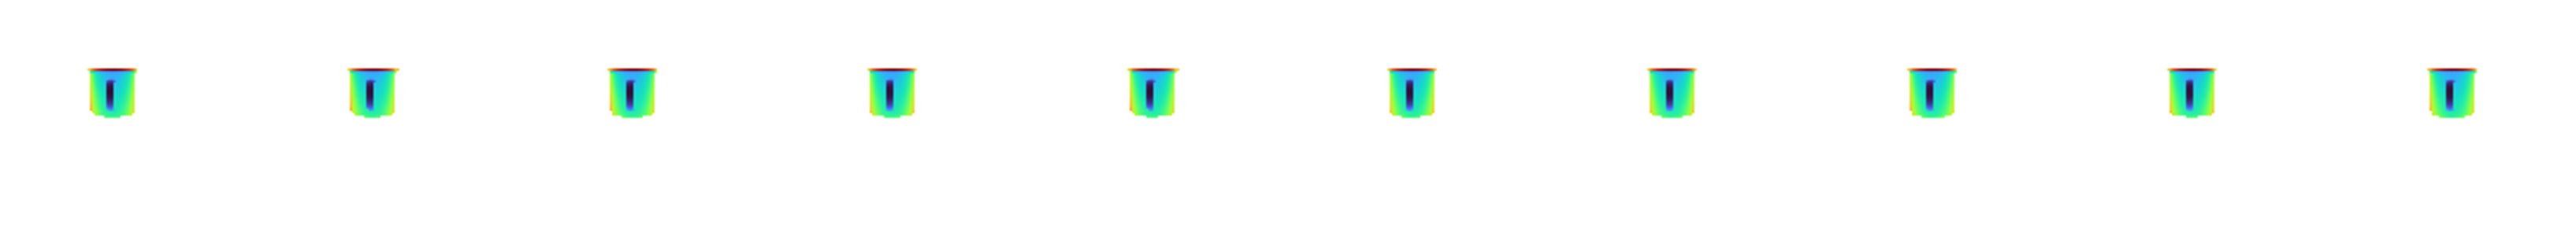

In [333]:
contact_param_grid = gt_cp + contact_param_deltas
scores =  jnp.concatenate([
    score_vmap(b.RENDERER.render_many(cp_to_pose_parallel(cps)[:,None,...], jnp.array([13]))[...,:3], obs_img)
    for cps in jnp.array_split(contact_param_grid, 15)
],axis=0)

sort_order = jnp.argsort(-scores)
sorted_scores = scores[sort_order]
k = 10
print("GT CP: ", gt_cp)
print(sorted_scores[:k])
print(contact_param_grid[sort_order[:k]])
poses = cp_to_pose_parallel(contact_param_grid[sort_order[:k]])[:,None,...]
rendered_top_k = b.RENDERER.render_many(poses, jnp.array([13]))[...,:3]


b.viz.scale_image(b.hstack_images([b.get_depth_image(i[...,2]) for i in rendered_top_k]),3.0)

9994


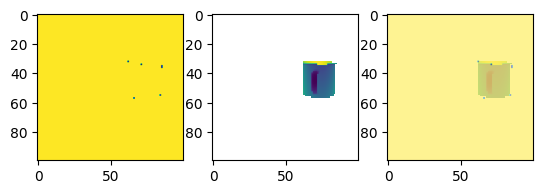

In [258]:
observed=obs_img
rendered=rendered_top_k[1]
distances = jnp.linalg.norm(observed - rendered, axis=-1)
matches = distances < 0.01
fig = plt.figure()
ax = fig.add_subplot(131)
print(matches.sum())
ax.imshow(matches)
ax = fig.add_subplot(132)
ax.imshow(b.viz.preprocess_for_viz(observed[...,2]))
ax = fig.add_subplot(133)
ax.imshow(b.viz.preprocess_for_viz(observed[...,2]),alpha=0.5)
ax.imshow(matches,alpha=0.5)

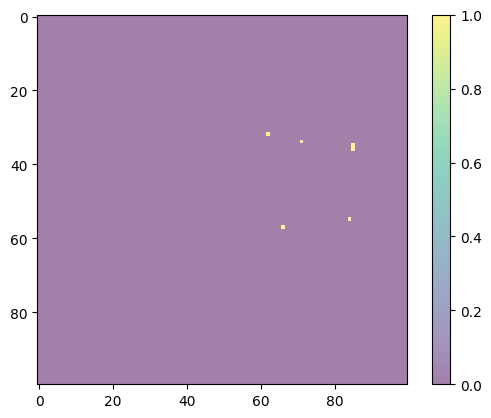

In [250]:
diffs = rendered_top_k[:,:,:,2] - obs_img[:,:,2][None,...]
i = 1

plt.imshow(jnp.abs(diffs[i]) > 0.01,alpha=0.5)
plt.colorbar()

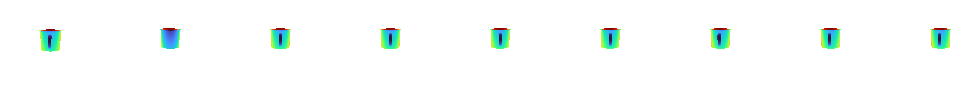

In [214]:
cp = jnp.zeros(3)
cps = [cp]
poses = [cp_to_pose_jit(cp)]
for cp_grid in contact_param_gridding_schedule:
    contact_param_grid = cp + cp_grid
    cp_poses = cp_to_pose_parallel(contact_param_grid)
    scores = score_vmap(b.RENDERER.render_many(cp_poses[:,None,...], jnp.array([13]))[...,:3], obs_img)
    best_idx = jnp.argmax(scores)
    cp = contact_param_grid[best_idx]
    cps.append(cp)
    poses.append(cp_poses[best_idx])
images_over_time = b.RENDERER.render_many(cp_to_pose_parallel(jnp.stack(cps))[:,None,...], jnp.array([13]))[...,:3]

b.clear()
b.show_cloud("1", obs_img.reshape(-1,3))
colors = b.distinct_colors(len(images_over_time))
b.show_trimesh(f"gt", b.RENDERER.meshes[13], opacity=0.5, color=b.RED)
b.set_pose(f"gt", gt_pose)
for i in range(len(images_over_time)):
    b.show_trimesh(f"_{i}", b.RENDERER.meshes[13], opacity=0.5, color=colors[i])
    b.set_pose(f"_{i}", poses[i])
    
b.hstack_images([b.get_depth_image(i[...,2]) for i in images_over_time])

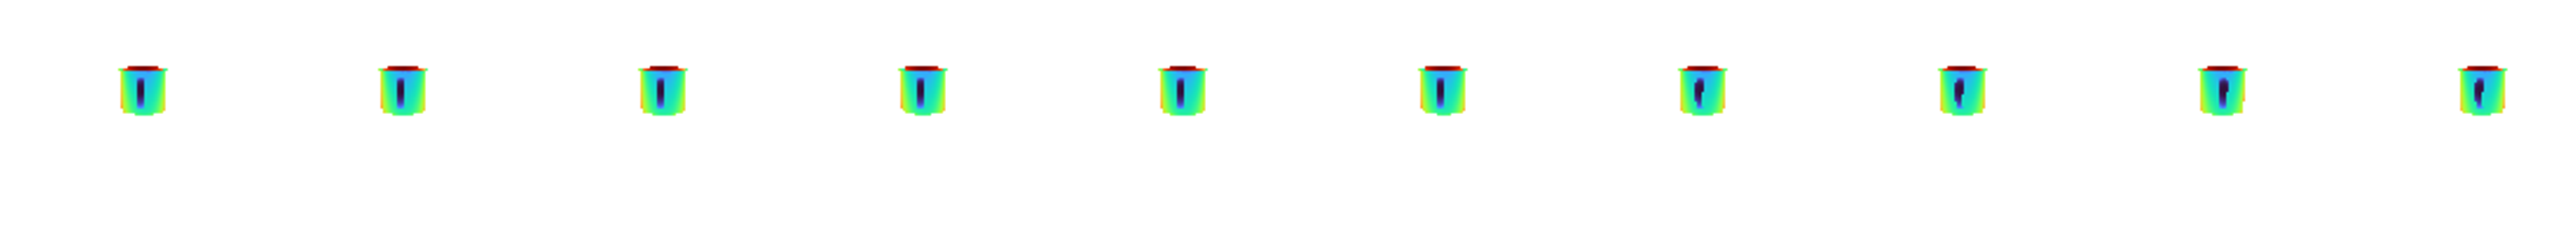

In [215]:
contact_param_grid = cp + contact_param_deltas
scores =  jnp.concatenate([
    score_vmap(b.RENDERER.render_many(cp_to_pose_parallel(cps)[:,None,...], jnp.array([13]))[...,:3], obs_img)
    for cps in jnp.array_split(contact_param_grid, 15)
],axis=0)

sort_order = jnp.argsort(-scores)
sorted_scores = scores[sort_order]
k = 10
# print("GT CP: ", gt_cp)
# print(sorted_scores[:k])
# print(contact_param_grid[sort_order[:k]])
poses = cp_to_pose_parallel(contact_param_grid[sort_order[:k]])[:,None,...]
rendered_top_k = b.RENDERER.render_many(poses, jnp.array([13]))[...,:3]


b.viz.scale_image(b.hstack_images([b.get_depth_image(i[...,2]) for i in rendered_top_k]),3.0)

In [211]:
sorted_scores[:10]

Array([9995, 9994, 9994, 9993, 9992, 9991, 9991, 9990, 9990, 9988], dtype=int32)

In [208]:
b.clear()
# b.show_cloud("1", obs_img.reshape(-1,3))
b.show_trimesh(f"gt", b.RENDERER.meshes[13], opacity=0.5, color=b.RED)
b.set_pose(f"gt", gt_pose)
colors = b.distinct_colors(len(poses))
for i in range(len(poses)):
    b.show_trimesh(f"_{i}", b.RENDERER.meshes[13], opacity=0.5, color=colors[i])
    b.set_pose(f"_{i}", poses[i])

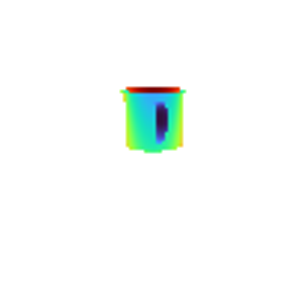

In [181]:
b.clear()
b.show_cloud("1", obs_img.reshape(-1,3))
b.show_cloud("3", rendered_top_k[1].reshape(-1,3), color=b.RED)
b.viz.scale_image(b.hstack_images([b.get_depth_image(i[...,2]) for i in rendered_top_k]),3.0)

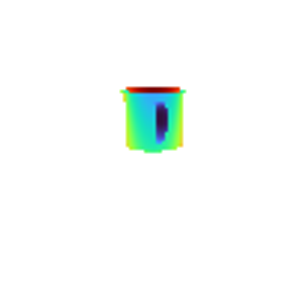

In [182]:
b.clear()
b.show_cloud("1", obs_img.reshape(-1,3))
b.show_cloud("3", rendered_top_k[1].reshape(-1,3), color=b.RED)
b.viz.scale_image(b.hstack_images([b.get_depth_image(i[...,2]) for i in rendered_top_k]),3.0)

In [184]:
b.clear()
b.show_cloud("1", obs_img.reshape(-1,3))
colors = b.distinct_colors(len(images_over_time))
for i in range(len(images_over_time)):
    b.show_cloud(f"_{i}", images_over_time[i].reshape(-1,3), color=colors[i])

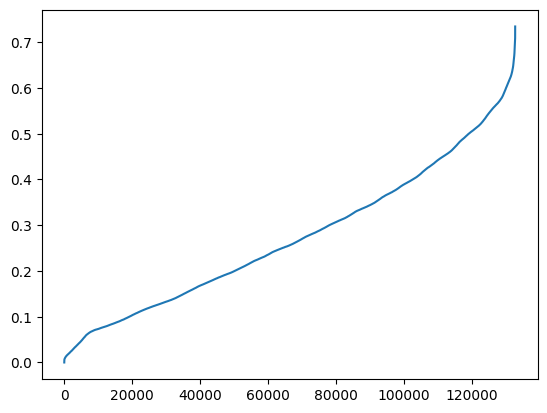

In [146]:
plt.plot(jnp.sort(scores))

In [9]:
contact_param_grid = trace["contact_params_1"] + contact_param_deltas
images =  jnp.concatenate([
    enumerators[2](trace, key, cp)["image"]
    for cp in jnp.array_split(contact_param_grid, 15)
],axis=0)

2023-10-31 17:54:05.814466: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.32GiB (rounded to 1414883072)requested by op 
2023-10-31 17:54:05.814708: W external/tsl/tsl/framework/bfc_allocator.cc:497] ************************************************************************************************____
2023-10-31 17:54:05.815647: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1414883032 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   221.7KiB
              constant allocation:       380B
        maybe_live_out allocation:    2.98GiB
     preallocated temp allocation:    1.32GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    4.29GiB
              total fragmentation:    1.32GiB (30.68%)
Peak buffers:
	Buffer 1:
		Size: 1.32GiB
	

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1414883032 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   221.7KiB
              constant allocation:       380B
        maybe_live_out allocation:    2.98GiB
     preallocated temp allocation:    1.32GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    4.29GiB
              total fragmentation:    1.32GiB (30.68%)
Peak buffers:
	Buffer 1:
		Size: 1.32GiB
		Operator: op_name="jit(enumerator)/jit(main)/vmap(jit(_render_custom_call))/jit(_render_custom_call)/render_multiple_140186662035616" source_file="/home/nishadgothoskar/bayes3d/bayes3d/renderer.py" source_line=159
		XLA Label: custom-call
		Shape: f32[8843,100,100,4]
		==========================

	Buffer 2:
		Size: 1012.00MiB
		XLA Label: fusion
		Shape: f32[8843,100,100,3]
		==========================

	Buffer 3:
		Size: 1012.00MiB
		Operator: op_name="jit(enumerator)/jit(main)/broadcast_in_dim[shape=(8843, 100, 100, 3) broadcast_dimensions=(1, 2, 3)]" source_file="/var/tmp/ipykernel_376442/2325666790.py" source_line=3
		XLA Label: fusion
		Shape: f32[8843,100,100,3]
		==========================

	Buffer 4:
		Size: 1012.00MiB
		Operator: op_name="jit(enumerator)/jit(main)/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1, 2, 3), collapsed_slice_dims=(), start_index_map=(3,)) slice_sizes=(8843, 100, 100, 3) unique_indices=True indices_are_sorted=True mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/home/nishadgothoskar/bayes3d/bayes3d/genjax/model.py" source_line=129
		XLA Label: fusion
		Shape: f32[8843,100,100,3]
		==========================

	Buffer 5:
		Size: 2.23MiB
		Operator: op_name="jit(enumerator)/jit(main)/broadcast_in_dim[shape=(8843, 22, 3) broadcast_dimensions=(1, 2)]" source_file="/var/tmp/ipykernel_376442/2325666790.py" source_line=3
		XLA Label: fusion
		Shape: f32[8843,22,3]
		==========================

	Buffer 6:
		Size: 1.08MiB
		Operator: op_name="jit(enumerator)/jit(main)/vmap(while)/body/add" source_file="/home/nishadgothoskar/bayes3d/bayes3d/scene_graph.py" source_line=195
		XLA Label: fusion
		Shape: f32[8843,2,4,4]
		==========================

	Buffer 7:
		Size: 1.08MiB
		Operator: op_name="jit(enumerator)/jit(main)/broadcast_in_dim[shape=(8843, 2, 4, 4) broadcast_dimensions=(1, 2, 3)]" source_file="/home/nishadgothoskar/bayes3d/bayes3d/genjax/model.py" source_line=129
		XLA Label: fusion
		Shape: f32[8843,2,4,4]
		==========================

	Buffer 8:
		Size: 759.9KiB
		XLA Label: fusion
		Shape: s32[8843,22]
		==========================

	Buffer 9:
		Size: 759.9KiB
		XLA Label: fusion
		Shape: s32[8843,22]
		==========================

	Buffer 10:
		Size: 759.9KiB
		Operator: op_name="jit(enumerator)/jit(main)/broadcast_in_dim[shape=(8843, 22) broadcast_dimensions=(1,)]" source_file="/var/tmp/ipykernel_376442/2325666790.py" source_line=3
		XLA Label: fusion
		Shape: s32[8843,22]
		==========================

	Buffer 11:
		Size: 552.7KiB
		Operator: op_name="jit(enumerator)/jit(main)/broadcast_in_dim[shape=(8843, 4, 4) broadcast_dimensions=(1, 2)]" source_file="/var/tmp/ipykernel_376442/2325666790.py" source_line=3
		XLA Label: fusion
		Shape: f32[8843,4,4]
		==========================

	Buffer 12:
		Size: 552.7KiB
		Operator: op_name="jit(enumerator)/jit(main)/broadcast_in_dim[shape=(8843, 4, 4) broadcast_dimensions=(1, 2)]" source_file="/var/tmp/ipykernel_376442/2325666790.py" source_line=3
		XLA Label: fusion
		Shape: f32[8843,4,4]
		==========================

	Buffer 13:
		Size: 552.7KiB
		Operator: op_name="jit(enumerator)/jit(main)/broadcast_in_dim[shape=(8843, 4, 4) broadcast_dimensions=(1, 2)]" source_file="/var/tmp/ipykernel_376442/2325666790.py" source_line=3
		XLA Label: fusion
		Shape: f32[8843,4,4]
		==========================

	Buffer 14:
		Size: 207.3KiB
		Operator: op_name="jit(enumerator)/jit(main)/concatenate[dimension=1]" source_file="/home/nishadgothoskar/bayes3d/bayes3d/genjax/model.py" source_line=129
		XLA Label: fusion
		Shape: f32[8843,2,3]
		==========================

	Buffer 15:
		Size: 207.3KiB
		Operator: op_name="jit(enumerator)/jit(main)/broadcast_in_dim[shape=(8843, 2, 3) broadcast_dimensions=(1, 2)]" source_file="/var/tmp/ipykernel_376442/2325666790.py" source_line=3
		XLA Label: fusion
		Shape: f32[8843,2,3]
		==========================



In [33]:
traces = enumerators[3](trace, key, contact_param_deltas + trace["contact_params_1"])

2023-10-31 17:52:05.703445: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.71GiB (rounded to 26530202112)requested by op 
2023-10-31 17:52:05.704126: W external/tsl/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2023-10-31 17:52:05.704853: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 26530201912 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.63MiB
              constant allocation:       376B
        maybe_live_out allocation:   518.2KiB
     preallocated temp allocation:   24.71GiB
  preallocated temp fragmentation:       188B (0.00%)
                 total allocation:   24.71GiB
              total fragmentation:   403.2KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 19.77Gi

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 26530201912 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.63MiB
              constant allocation:       376B
        maybe_live_out allocation:   518.2KiB
     preallocated temp allocation:   24.71GiB
  preallocated temp fragmentation:       188B (0.00%)
                 total allocation:   24.71GiB
              total fragmentation:   403.2KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 19.77GiB
		Operator: op_name="jit(enumerator_score)/jit(main)/vmap(jit(_render_custom_call))/jit(_render_custom_call)/render_multiple_140068952562704" source_file="/home/nishadgothoskar/bayes3d/bayes3d/renderer.py" source_line=159
		XLA Label: custom-call
		Shape: f32[132651,100,100,4]
		==========================

	Buffer 2:
		Size: 4.94GiB
		Operator: op_name="jit(enumerator_score)/jit(main)/reduce_max[axes=(3, 4)]" source_file="/home/nishadgothoskar/bayes3d/bayes3d/likelihood.py" source_line=33
		XLA Label: fusion
		Shape: f32[100,100,132651]
		==========================

	Buffer 3:
		Size: 1.52MiB
		Entry Parameter Subshape: f32[132651,3]
		==========================

	Buffer 4:
		Size: 518.2KiB
		Operator: op_name="jit(enumerator_score)/jit(main)/add" source_file="/home/nishadgothoskar/bayes3d/bayes3d/genjax/model.py" source_line=129
		XLA Label: fusion
		Shape: f32[132651]
		==========================

	Buffer 5:
		Size: 117.2KiB
		Entry Parameter Subshape: f32[100,100,3]
		==========================

	Buffer 6:
		Size: 264B
		Entry Parameter Subshape: f32[22,3]
		==========================

	Buffer 7:
		Size: 64B
		XLA Label: constant
		Shape: f32[4,4]
		==========================

	Buffer 8:
		Size: 64B
		Entry Parameter Subshape: f32[4,4]
		==========================

	Buffer 9:
		Size: 64B
		Entry Parameter Subshape: f32[4,4]
		==========================

	Buffer 10:
		Size: 64B
		Entry Parameter Subshape: f32[4,4]
		==========================

	Buffer 11:
		Size: 56B
		XLA Label: tuple
		Shape: (s32[], f32[132651,2,4,4], s32[2], f32[2,3], s32[2], /*index=5*/f32[132651,2,3], s32[2])
		==========================

	Buffer 12:
		Size: 48B
		Operator: op_name="jit(enumerator_score)/jit(main)/vmap(while)/body/concatenate[dimension=1]" source_file="/home/nishadgothoskar/bayes3d/bayes3d/transforms_3d.py" source_line=29
		XLA Label: fusion
		Shape: (f32[16,4], f32[16,4], f32[16,4], f32[16,4], f32[16,4], /*index=5*/f32[16,4])
		==========================

	Buffer 13:
		Size: 36B
		XLA Label: constant
		Shape: f32[3,3]
		==========================

	Buffer 14:
		Size: 36B
		XLA Label: constant
		Shape: f32[3,3]
		==========================

	Buffer 15:
		Size: 36B
		XLA Label: constant
		Shape: f32[3,3]
		==========================



In [21]:
enumerators = b.make_enumerator(["contact_params_1"])

In [22]:
key = jax.random.PRNGKey(100)

In [8]:
def make_orientation_posterior_viz(observation, gt_contact, sampled_contacts):
    fig = plt.figure(constrained_layout=True)
    # fig.suptitle(f"Variance: {variance} Outlier Prob: {outlier_prob}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2],max=1.4)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Observation (params {gt_contact[0]:0.2f}, {gt_contact[1]:0.2f} ,{gt_contact[2]:0.2f})")
    # ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.set_aspect(1.0)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linestyle="--", linewidth=0.5)
    ax.add_patch(circ)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.scatter(-jnp.sin(sampled_contacts[:,2]),jnp.cos(sampled_contacts[:,2]), color='red',label="Posterior Samples", alpha=0.5, s=30)
    ax.scatter(-jnp.sin(gt_contact[2]),jnp.cos(gt_contact[2]), label="Actual", alpha=0.9, s=25)
    ax.set_title("Posterior on Orientation (top view)")
    # ax.legend(fontsize=9)
    # plt.show()
    return fig

In [9]:
def c2f_contact_update(trace_, key, contact_param_deltas):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_1"]
    scores = enumerators[3](trace_, key, contact_param_grid)
    i = scores.argmax()
    return enumerators[0](
        trace_, key,
        contact_param_grid[i]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update)

In [10]:
key = jax.random.PRNGKey(100)
key2 = jax.random.PRNGKey(1000)

In [11]:
grid_params = [
    (0.3, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)), (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)), (0.02, jnp.pi, (9,9,51)), (0.01, jnp.pi/5, (15,15,15)), (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [12]:
key = jax.random.split(key,2)[0]

[ 0.04660907 -0.12123723  0.5363271 ]


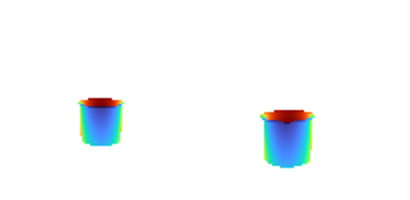

In [13]:
low, high = jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(21),
    "id_1": jnp.int32(13),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 3,
    "face_child_1": 2,
    "variance": 0.0001,
    "outlier_prob": 0.0001,
    "contact_params_1": jax.random.uniform(key, shape=(3,),minval=low, maxval=high)
}), (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.5, -0.5, -2*jnp.pi]), jnp.array([0.5, 0.5, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
)
gt_poses = b.get_poses(trace)
gt_contact = trace["contact_params_1"]
print(gt_contact)
trace = b.update_address(trace, key, "contact_params_1", jnp.zeros(3))
b.viz_trace_rendered_observed(trace)

[ 0.04285719 -0.11999999  0.19747186]
CPU times: user 11.2 s, sys: 139 ms, total: 11.3 s
Wall time: 10.3 s


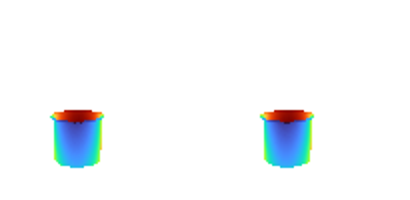

In [14]:
%%time
path = []
path.append(trace)
for c2f_iter in range(len(contact_param_gridding_schedule)):
    trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])
    path.append(trace)
print(trace["contact_params_1"])
b.viz_trace_rendered_observed(trace)

In [15]:
%%time
contact_param_grid = trace["contact_params_1"] + contact_param_deltas
weights =  jnp.concatenate([
    enumerators[3](trace, key, cp)
    for cp in jnp.array_split(contact_param_grid, 15)
],axis=0)

CPU times: user 6.77 s, sys: 27.7 ms, total: 6.8 s
Wall time: 6.43 s


In [16]:
key2 = jax.random.split(key, 1)[0]
normalized_weights = b.utils.normalize_log_scores(weights)
sampled_indices = jax.random.choice(key2,jnp.arange(normalized_weights.shape[0]), shape=(2000,), p=normalized_weights)
sampled_contact_params = contact_param_grid[sampled_indices]

In [18]:
sampled_contact_params

Array([[ 0.03685719, -0.11999999, -0.30518305],
       [ 0.03685719, -0.11999999, -0.30518305],
       [ 0.04285719, -0.11999999,  0.19747186],
       ...,
       [ 0.04285719, -0.11999999,  0.19747186],
       [ 0.04285719, -0.11999999,  0.19747186],
       [ 0.03565719, -0.12119999, -0.4308468 ]], dtype=float32)

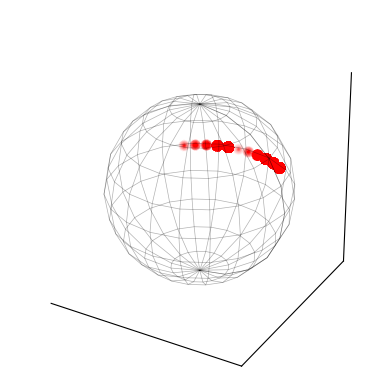

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
u, v = np.mgrid[0:2*np.pi:21j, 0:np.pi:11j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.axes.set_xlim3d(-1.1, 1.1) 
ax.axes.set_ylim3d(-1.1, 1.1) 
ax.axes.set_zlim3d(-1.1, 1.1) 
ax.set_aspect("equal")
ax.plot_wireframe(x, y, z, color=(0.0, 0.0, 0.0, 0.3), linewidths=0.5)


ax.axes.set_zticks([])
ax.axes.set_xticks([])
ax.axes.set_yticks([])

points = []
NUM = 1
offset = jnp.pi/2
scaling = 0.96
for i in sampled_contact_params:
    points.append(np.array([np.cos(i[2] + offset) * scaling, np.sin(i[2] + offset) * scaling,0.0]))
points = np.array(points)

z = 0.1
for i in np.arange(.1,1.01,.1):
    ax.scatter(points[:,0], points[:,1],points[:,2], s=(40*i*(z*.9+.1))**2, color=(1,0,0,.3/i/10))
# offset = jnp.pi/2
# angle = jnp.pi/4 - jnp.pi/4 - jnp.pi/4 - jnp.pi/4
# for i in np.arange(.1,1.01,.1):
#     ax.scatter(np.cos(angle + offset) * scaling, np.sin(angle + offset), 0.0, s=(40*i*(z*.9+.1))**2, color=(1,0,0,.3))

# plt.tight_layout()
plt.savefig("sphere.pdf")

In [ ]:
scaled_up_intrinsics = b.scale_camera_parameters(intrinsics, 4)

b.setup_renderer(scaled_up_intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

In [ ]:
img = b.RENDERER.render(gt_poses, b.get_indices(trace))

In [ ]:
depth = img[...,2]
minval = jnp.min(depth[depth > jnp.min(depth)])
maxval = jnp.max(depth[depth < jnp.max(depth)])
depth = depth.at[depth >= intrinsics.far].set(jnp.nan)
viz_img = np.array(b.viz.scale_image(b.get_depth_image(
   depth, min=minval,  max=maxval
), 3))
viz_img[viz_img.sum(-1) == 0,:] = 255.0
plt.imshow(viz_img)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("mug.pdf")

In [ ]:
sampled_contact_params

In [ ]:
points

In [ ]:
jnp.linalg.norm(points,axis=-1)

In [ ]:
points

In [ ]:

fig = plt.figure(constrained_layout=True)

observation =  trace["image"]

# fig.suptitle(f"Variance: {variance} Outlier Prob: {outlier_prob}")
widths = [1, 1]
heights = [2]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax = fig.add_subplot(spec[0, 0])
ax.imshow(jnp.array(b.get_depth_image(observation[...,2],max=1.4)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(f"Observation (params {gt_contact[0]:0.2f}, {gt_contact[1]:0.2f} ,{gt_contact[2]:0.2f})")
# ax.set_title(f"Observed Depth")


dist = 0.6
ax = fig.add_subplot(spec[0, 1])
ax.quiver(
    sampled_contact_params[:,0],sampled_contact_params[:,1],
    -jnp.sin(sampled_contact_params[:,2]),jnp.cos(sampled_contact_params[:,2]),
    scale=3.0,
    alpha=0.1
         )

ax.quiver(
    gt_contact[0],gt_contact[1],
    -jnp.sin(gt_contact[2]), jnp.cos(gt_contact[2]),
    scale=5.0,
    alpha=0.8,
    color="red"
)

ax.set_aspect(1.0)
from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((gt_contact[0]-width, gt_contact[1]-width), 2*width, 2*width,fill=None))

ax.set_xlim(gt_contact[0]-width-0.02, gt_contact[0]+width+0.02)
ax.set_ylim(gt_contact[1]-width-0.02, gt_contact[1]+width+0.02)

In [ ]:
best_cell_idx = jnp.abs(contact_param_grid - gt_contact).sum(1).argmin()
print(gt_contact, contact_param_grid[best_cell_idx])
normalize_log_weights = w1eights - b.logsumexp(weights)
assert(weights.shape[0] == contact_param_grid.shape[0])
volume = (width / num_position_grids)**2 * (2*jnp.pi / num_angle_grids)
log_likelihood = normalize_log_weights[best_cell_idx] - jnp.log(volume)
print(log_likelihood)